In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from joblib import Parallel, delayed, cpu_count

from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline

import sys
import warnings

warnings.filterwarnings("ignore")

### Preliminary investigation of the data - PCA + KMeans Scree Plot using sklearn

In [2]:
data = np.loadtxt("high_variance_distances.dat")
data_pts = data.copy()
print(data.shape)

(7500, 177)


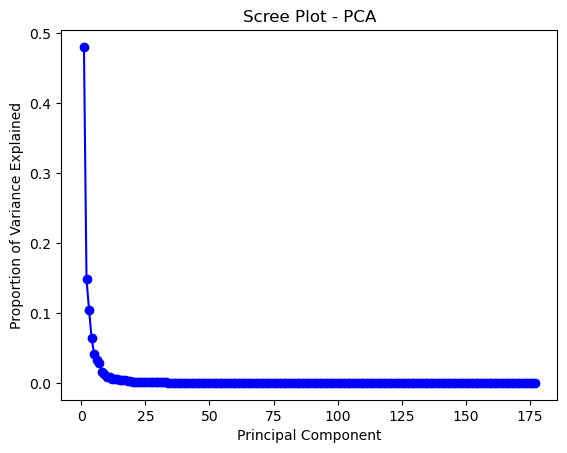

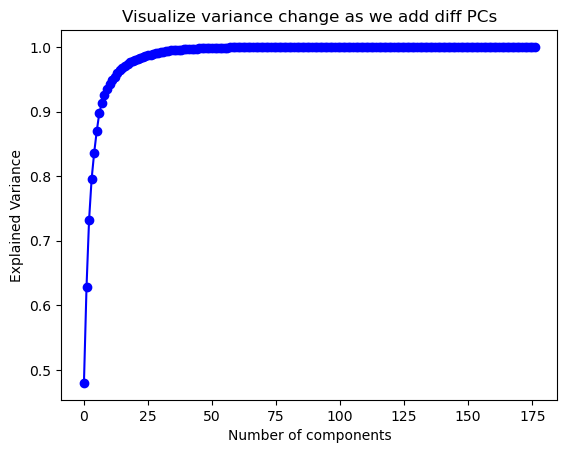

50
150
250
350
450
550
650
750
850
950
CPU times: user 9min 22s, sys: 1min 48s, total: 11min 10s
Wall time: 1min 18s


In [3]:
%%time

pca = PCA()
pca.fit(data)
new_data = pca.transform(data)

PC_values = np.arange(pca.n_components_) + 1

plt.title("Scree Plot - PCA")
plt.plot(PC_values, pca.explained_variance_ratio_, "bo-")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()

plt.title("Visualize variance change as we add diff PCs")
plt.ylabel("Explained Variance")
plt.xlabel("Number of components")
plt.plot(np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.show()

# Sklearn Kmeans error estimation to be used for comparing with my own code later
obj_list_skl = []
kmin = 50
kmax = 1050
kstep = 100
for k in range(kmin, kmax, kstep):
    print(k)
    kmeans = KMeans(n_clusters=k).fit(data)
    obj_min = kmeans.inertia_
    obj_list_skl.append(obj_min)

# Find microstates by KMeans/KMeans++/KMedoids

In [4]:
class kmeans:
    # Initialize the class
    def __init__(self, num_clusters):
        self.num_centroids = num_clusters

    # Function for random initialization
    def init_centroids_random(self):
        select_centroids = np.random.choice(self.num_points, size=self.num_centroids, replace=False)
        return self.data[select_centroids]

    # Function for KMeans++ initialization
    def init_centroids_pp(self):
        i = rd.randint(0, self.num_points - 1)
        centroids = np.array([self.data[i]])
        for k in range(1, self.num_centroids):
            D = np.array([])
            D = np.append(D, np.min(cdist(self.data, centroids, "sqeuclidean"), axis=1))
            prob = D / np.sum(D)
            cum_prob = np.cumsum(prob)
            r = rd.random()
            i = 0
            for j, p in enumerate(cum_prob):
                if r < p:
                    i = j
                    break
            centroids = np.append(centroids, [self.data[i]], axis=0)
        return centroids

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, init="random", max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]

        if init == "k-means++":
            self.centroid_positions = self.init_centroids_pp()
        else:
            self.centroid_positions = self.init_centroids_random()

        for count in range(max_iterations):
            dist_sq_matrix = cdist(self.data, self.centroid_positions, "sqeuclidean")
            min_dist = np.array([np.min(dist_sq_matrix, axis=1)])
            self.labels = np.argmin(dist_sq_matrix, axis=1)
            loss = min_dist.sum()
            skip = False
            for i in range(self.num_centroids):
                if len(self.data[self.labels == i]) == 0:
                    skip = True
            if skip == True:
                self.centroid_positions = self.init_centroids_random()
                continue
            new_centroids = np.array(
                [self.data[self.labels == i].mean(axis=0) for i in range(self.num_centroids)]
            )
            if np.all(self.centroid_positions == new_centroids):
                break
            self.centroid_positions = new_centroids

        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, new_centroids, self.labels

    # Plot Clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_centroids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for centroid in range(self.num_centroids):
            array_points = self.data[self.labels == centroid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[centroid], s=4)
        plt.scatter(self.centroid_positions[:, 0], self.centroid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final centroid positions
    def get_centroid_positions(self):
        return self.centroid_positions

In [5]:
class kmedoids:
    # Initialize the class
    def __init__(self, num_medoids):
        self.num_medoids = num_medoids

    # Function for random initialization
    def init_medoids_random(self):
        select_medoids = np.random.choice(self.num_points, size=self.num_medoids, replace=False)
        return select_medoids

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]
        medoid_idxs = self.init_medoids_random()

        D = cdist(self.data, self.data, "sqeuclidean")

        for count in range(max_iterations):
            old_medoid_idxs = np.copy(medoid_idxs)
            labels = np.argmin(D[medoid_idxs, :], axis=0)
            self.update_medoids(D, labels, medoid_idxs)
            if np.all(old_medoid_idxs == medoid_idxs):
                break

        self.medoid_positions = self.data[medoid_idxs]
        self.labels = np.argmin(D[medoid_idxs, :], axis=0)
        dist_sq_matrix = cdist(self.data, self.medoid_positions, "sqeuclidean")
        min_dist = np.array([np.min(dist_sq_matrix, axis=1)])
        loss = min_dist.sum()

        new_medoids = self.medoid_positions

        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, new_medoids, self.labels

    # Function to update medoid positions
    def update_medoids(self, D, labels, medoid_idxs):
        for k in range(self.num_medoids):
            cluster_k_indexes = np.where(labels == k)[0]
            if len(cluster_k_indexes) == 0:
                continue
            intra_cluster_distances = D[cluster_k_indexes, cluster_k_indexes[:, np.newaxis]]
            intra_cluster_all_costs = np.sum(intra_cluster_distances, axis=1)
            min_cost_index = np.argmin(intra_cluster_all_costs)
            min_cost = intra_cluster_all_costs[min_cost_index]
            curr_cost = intra_cluster_all_costs[np.argmax(cluster_k_indexes == medoid_idxs[k])]
            if min_cost < curr_cost:
                medoid_idxs[k] = cluster_k_indexes[min_cost_index]

    # Plot the clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_medoids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for medoid in range(self.num_medoids):
            array_points = self.data[self.labels == medoid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[medoid], s=4)
        plt.scatter(self.medoid_positions[:, 0], self.medoid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final medoid positions
    def get_medoid_positions(self):
        return self.medoid_positions

In [6]:
def plot_clusters(data, centroids, labels):
    colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, centroids.shape[0]))

    for i in range(centroids.shape[0]):
        cluster = data[labels == i]
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], s=4)

    title_text = "N = %d, k = %d" % (centroids.shape[0], labels.shape[0])
    plt.title(title_text)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="k")
    plt.show()

## Test for KMeans (random initialization)

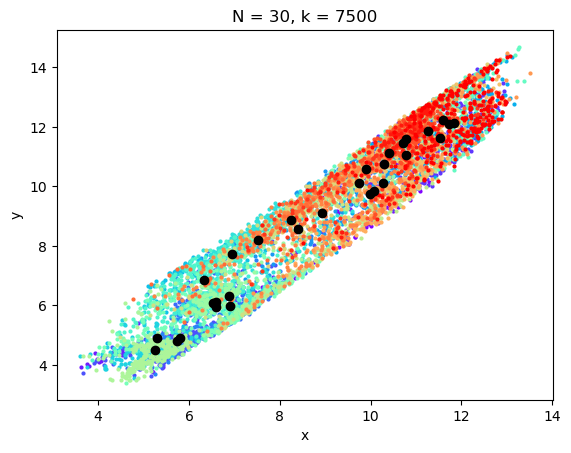

Average Loss =  2671013.4928262862
Minimum Loss =  2646228.851837619
Simulation Run corresponding to least loss =  9
Average number of iterations to converge =  56.0
CPU times: user 442 ms, sys: 259 ms, total: 701 ms
Wall time: 4.54 s


In [7]:
%%time

num_simulations = 10
test_km = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_km.fit)(data, init="random") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMeans (K-Means++ initialization)

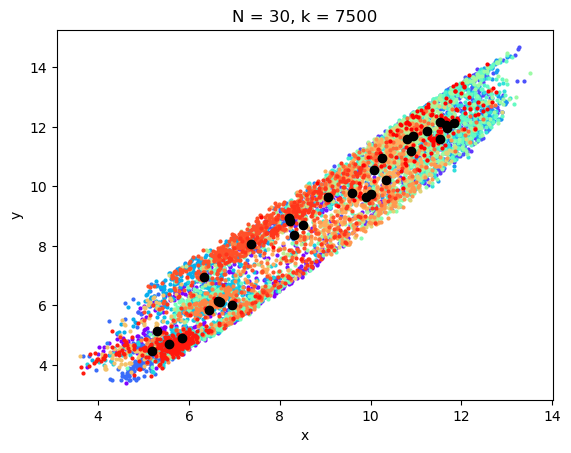

Average Loss =  2662305.7569339983
Minimum Loss =  2646064.513411211
Simulation Run corresponding to least loss =  8
Average number of iterations to converge =  53.1
CPU times: user 315 ms, sys: 25 ms, total: 340 ms
Wall time: 3.04 s


In [8]:
%%time

num_simulations = 10
test_kmpp = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmpp.fit)(data, init="k-means++") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMedoids

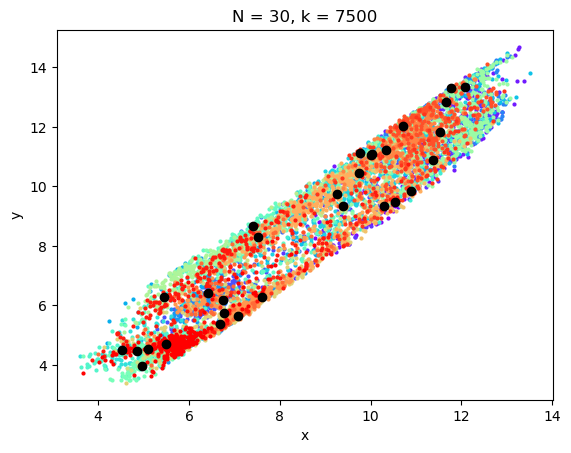

Average Loss =  3772859.1006858544
Minimum Loss =  3627140.8727529636
Simulation Run corresponding to least loss =  4
Average number of iterations to converge =  3.2
CPU times: user 282 ms, sys: 30.8 ms, total: 313 ms
Wall time: 7.98 s


In [9]:
%%time

num_simulations = 10
test_kmed = kmedoids(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmed.fit)(data) for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

### Based on these preliminary tests, error is minimum for KMeans++. But random initialization is pretty close and is way faster, so we proceed with that. We ignore KMedoids which has a much higher error.

### Now, let's do a scree plot for KMeans to try and choose an appropriate 'k' for future steps.

In [10]:
%%time

num_simulations = 10
res_k = []

kmin = 50
kmax = 1050
kstep = 100

for k in range(kmin, kmax, kstep):
    print(k)
    km = kmeans(k)

    results = Parallel(n_jobs=-1)(delayed(km.fit)(data, init="random") for i in range(num_simulations))
    losses = np.array([results[i][0] for i in range(num_simulations)])
    min_loss = results[np.argmin(losses)][0]

    print(k, min_loss)
    res_k.append([k, min_loss])

res_k = np.array(res_k)

50
50 2297664.531720329
150
150 1697303.404294857
250
250 1485708.8380261231
350
350 1351860.727163881
450
450 1259971.405987158
550
550 1188381.2967648269
650
650 1126429.4927939496
750
750 1076508.3274456179
850
850 1025981.7119369411
950
950 986503.5466724468
CPU times: user 350 ms, sys: 114 ms, total: 464 ms
Wall time: 1min 33s


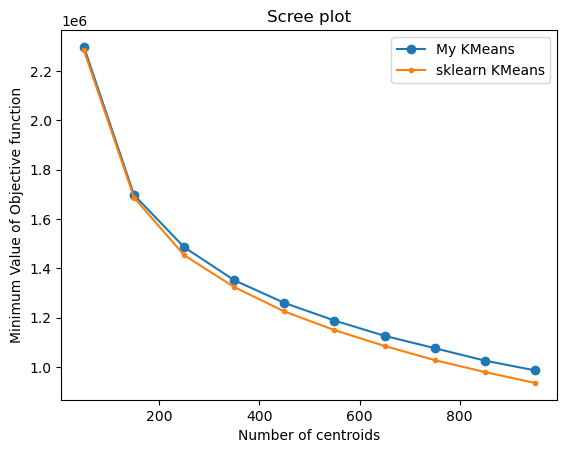

In [11]:
plt.plot(res_k[:, 0], res_k[:, 1], "o-", label="My KMeans")
plt.plot(np.arange(kmin, kmax, kstep), obj_list_skl, ".-", label="sklearn KMeans")
plt.title("Scree plot")
plt.ylabel("Minimum Value of Objective function")
plt.xlabel("Number of centroids")
plt.legend()

# Compute the transition matrix: $\pi_{\alpha, \beta} = P(\beta, \tau | \alpha, 0)$, for a given $\tau$

In [12]:
def transition_matrix(data, labels, k, tau):
    pi = np.zeros((k, k))
    for i in range(data.shape[0] - tau):
        alpha = labels[i]
        beta = labels[i + tau]
        pi[alpha, beta] += 1

    # print(pi)
    # print(np.sum(pi,axis=1,keepdims=True))

    pi = pi / np.sum(pi, axis=1, keepdims=True)

    # Check properties of a stochastic matrix
    # 1. All elements are positive-defined -> non-negative
    # 2. sum_(alpha) Pi(alpha,beta) = 1 (for all beta)
    assert np.size(np.where(pi < 0)[0]) == 0
    assert np.allclose(np.sum(pi, axis=1), 1.0, atol=1.0e-08)
    # print(pi)

    eigvals, eigvecs = np.linalg.eig(pi.T)

    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    sorted_eigvecs = eigvecs[:, sorted_index]

    # statdist = eigvecs[:, np.isclose(eigvals, 1)].ravel()
    # statdist /= np.sum(statdist)
    relaxation_timescales = -tau / np.log(np.abs(eigvals[np.isclose(eigvals, 1) == False]))

    # print(relaxation_timescales)

    return sorted_eigvals, sorted_eigvecs, relaxation_timescales

# Inspect the sign of the leading eigenvectors to identify the Markov states


1337382.6342791314 26


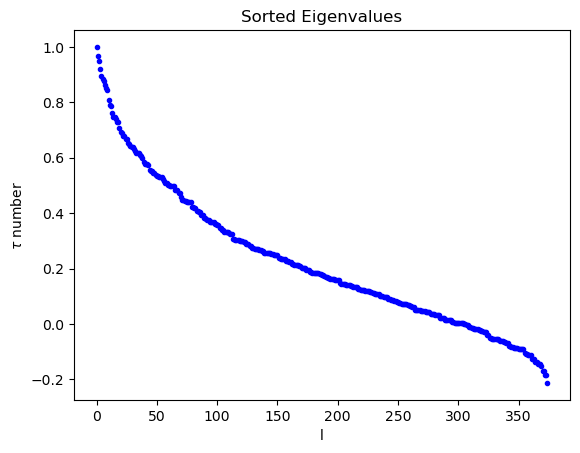

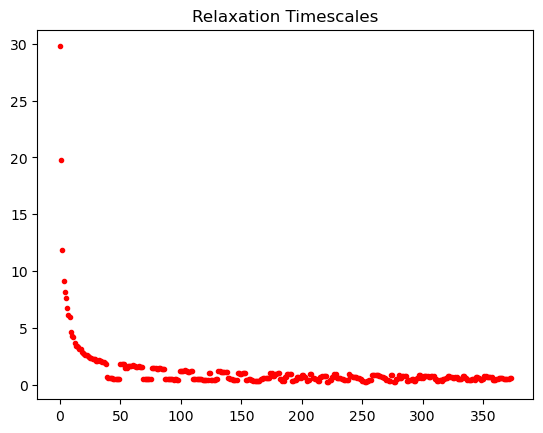

(375, 177)


In [13]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 1
eigvals, eigvecs, relaxation_timescales = transition_matrix(data, labels.astype(np.int64), k, tau)

# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

# centroid_positions = km.get_centroid_positions()
print(centroid_positions.shape)

In [14]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2
num_ms = num_timescales**2  # number of markov states is square of the number of relevant timescales

In [15]:
# Array to denote which centroid belongs to which Markov State
ms = np.zeros(k)

# print(ms)

# right eigenvectors of Pi sum to 0 except the first eigenvector which corresponds to eigenvalue=1
assert np.isclose(eigvecs[:, 1::].sum(axis=0), 0.0, atol=1.0e-08).all()

if num_ms == 1:
    for i in range(k):
        if eigvecs[i, 1] > 0:
            # evec[:,1] corresponds to the first eigenvector with a non=1 eigenvalue
            # since log of the eigval is taken, so that eigenvector (evec[:,0], eigval=1) is ignored
            ms[i] = -1
        else:
            ms[i] = +1
elif num_ms == 4:
    for i in range(k):
        if eigvecs[i, 1] > 0 and eigvecs[i, 2] > 0:
            ms[i] = -2
        elif eigvecs[i, 1] > 0 and eigvecs[i, 2] < 0:
            ms[i] = -1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] > 0:
            ms[i] = +1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] < 0:
            ms[i] = +2
else:
    print("Not explicitly implemented for more than 2 relevant timescales")

In [16]:
# Attempt to automate this markov state discovery pipeline for any general number of chosen relevant timescales
# There may be bugs here

# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2

# number of markov states is square of the number of relevant timescales
num_markov_states = num_timescales**2

markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

assert np.isclose((ms - markov_states), 0).all()
# print(markov_states)
# print(ms)
# print(ms-markov_states)

In [17]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-2.0 2.0


# Dimensional Reduction of original data and visualization of the Markov States

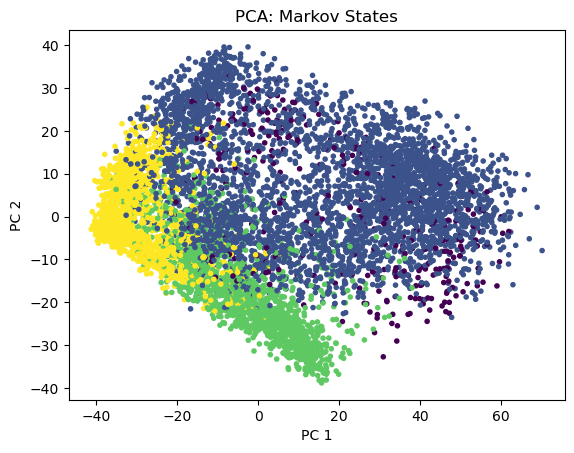

In [18]:
# 4: Dimensionality reduction and visualization
# Perform PCA on the microstates to obtain a 2D embedding

pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

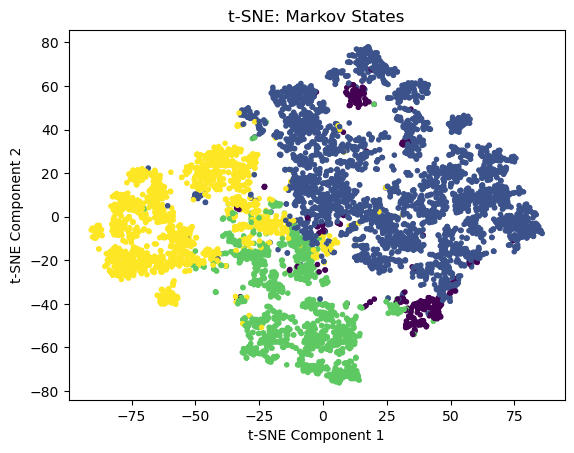

In [19]:
# 4: Dimensionality reduction and visualization
# Perform t-SNE on the microstates to obtain a 2D embedding
# perplexity refers to number of nearest neighbours chosen

data_2d_tsne = TSNE(n_components=2, perplexity=31, random_state=1729).fit_transform(data)

# Plot the Markov states in the embedding
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], marker=".", c=data_ms_assignation)
plt.title("t-SNE: Markov States")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Stability of results w.r.t. $\tau$ and $k$

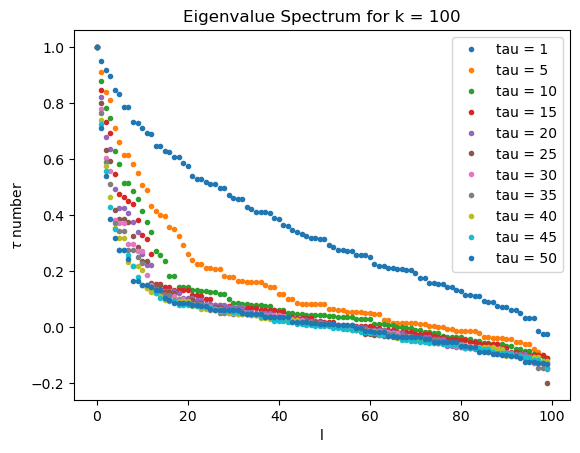

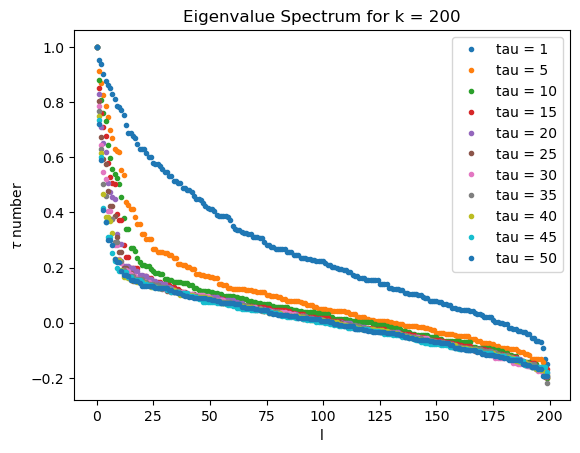

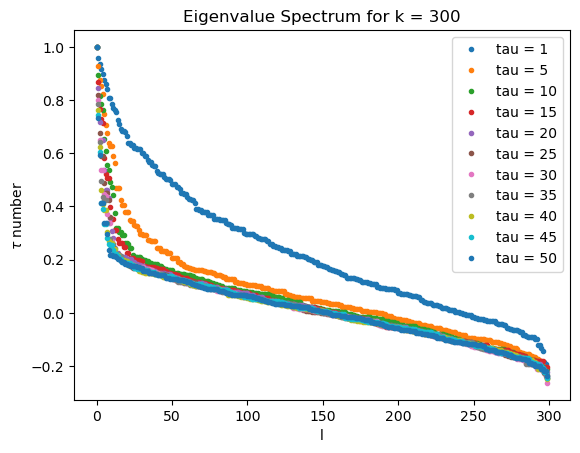

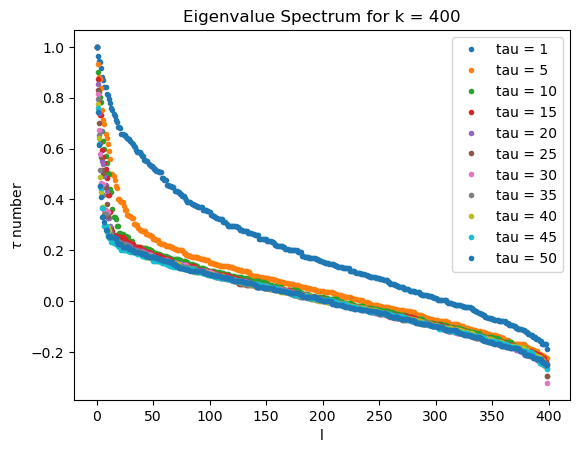

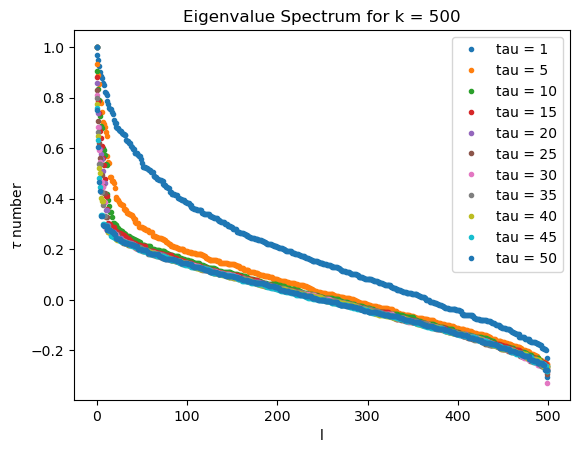

CPU times: user 21 s, sys: 419 ms, total: 21.4 s
Wall time: 26.8 s


In [20]:
%%time

ks = np.ones((5))
ks = np.cumsum(ks) * 100
# 100, ...., 500

taus = np.ones((11))
taus = np.cumsum(taus) * 5 - 5 + 1
taus[1:] = taus[1:] - 1
taus = taus.astype(np.int64)
# 1, 5, 10, ...., 50

for i in range(len(ks)):
    k_local = ks[i].astype(np.int64)
    kmi = kmeans(k_local)
    kmi.fit(data=data, init="random")
    labels_ks = kmi.get_assignation()
    labels_ks = labels_ks.astype(np.int64)

    title_text = "Eigenvalue Spectrum for k = %d" % (k_local)
    plt.title(title_text)
    plt.xlabel(r"l")
    plt.ylabel(r"$\tau$ number")

    # title_text = "Relaxation Timescales for k = %d" % (k_local)
    # plt.title(title_text)

    results = Parallel(n_jobs=2)(
        delayed(transition_matrix)(data, labels_ks, k_local, taus[t]) for t in range(len(taus))
    )
    eigvals_ks = np.array([results[i][0] for i in range(len(taus))])
    for i in range(len(taus)):
        plt.plot(eigvals_ks[i, :], ".", label=f"tau = {taus[i]}")

    # for t in range(len(taus)):
    #    eigvals_ks, eigvecs_ks, relaxation_timescales_ks = transition_matrix(data, labels_ks, k_local, taus[t])
    #    plt.plot(eigvals_ks, ".", label=f"tau = {taus[t]}")
    # plt.plot(relaxation_timescales_ks, ".", label=f"tau = {taus[t]}")

    plt.legend()
    plt.show()

## One observes that the eigenvalue spectrum is similar regardless of the value of $k$ chosen.

## For each $k$, only the behaviour of $\tau = 1$ is significantly different than other values of $\tau$, from $1-50$.

## So, let us also visualize the Markov States for a higher value of $\tau = 50$ (keeping $k = 375$ constant)

1334585.562307524 16


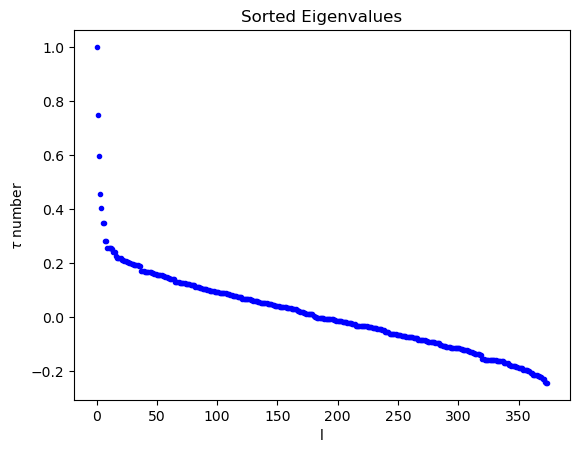

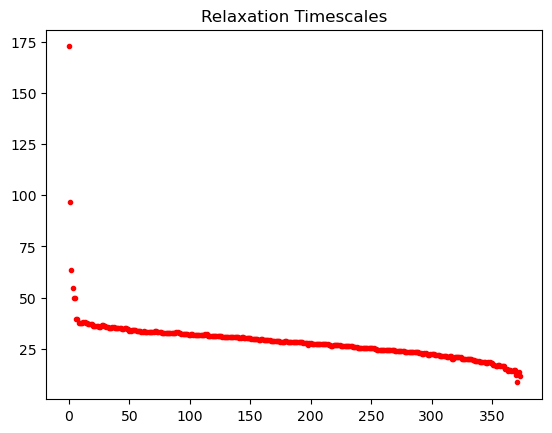

(375, 177)


In [21]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 50
eigvals, eigvecs, relaxation_timescales = transition_matrix(data, labels.astype(np.int64), k, tau)

# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

# centroid_positions = km.get_centroid_positions()
print(centroid_positions.shape)

In [22]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2
num_ms = num_timescales**2  # number of markov states is square of the number of relevant timescales

In [23]:
markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

# print(markov_states)

In [24]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-2.0 2.0


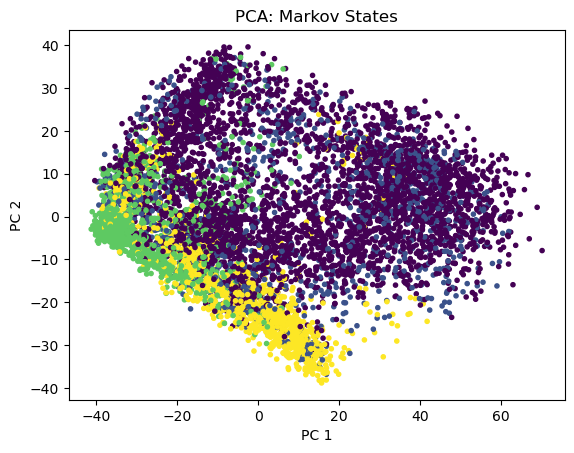

In [25]:
pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()